# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)
#X

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
# No poner tantos percentiles y maxdep grande  - > Manual
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2) # Calcula el gini de cada rama del árbol

In [7]:
def gini_impurity(X_col, y, split): # X_col: Toma la columna que necesito de X
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split # Particiones
    y_l = y.loc[filter_l] # Y Izquiero
    y_r = y.loc[~filter_l] # Y Derecho
    
    n_l = y_l.shape[0] 
    n_r = y_r.shape[0]
    
    gini_y = gini(y) # Gini Total (Antes de partir)
    gini_l = gini(y_l) # Gini izquierdo
    gini_r = gini(y_r) # Gini derecho
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r) # yo: Qué tan disimiles son los grupos
    
    return gini_impurity_

In [8]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist()) # np.percentil devuelve el valor del percentil
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1: # Si número de observaciones =1, split -1 porque ya no parte más
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction, suma 1 al numerador y 2 al denominador para que nunca de infinito
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain: # Si ganancia < minima ganancia, no haga nada
        return tree
    if max_depth is not None:
        if level >= max_depth: # Si ganancia > minima ganancia, retorna el árbol en el que voy
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split # X COMPLETA
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split] # Guarda la partición en el diccionario, array j, split
    tree['gain'] = gain

    # Next iteration to each split
      # PAra cada partición ejecuto de nuevo la función
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
def tree_predict(X, tree, proba=False): # yO: ojooooo DEBE HACERSE CON X_TEST
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [11]:
from sklearn.metrics import accuracy_score
tree = tree_grow(X_train, y_train, max_depth=4)
y_pred = tree_predict(X_test, tree)
print('Accuracy',accuracy_score(y_test, y_pred))

('Accuracy', 0.8334101382488479)


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [14]:
# - > Manual
# Yo: Definición de variables a usar más adelante
#max_depth = None
num_pct = 10
#max_features = None
#min_gain=0.001

#X_train.shape
n_samples = X_train.shape[0]

np.random.seed(12345)

boostrap = [np.random.choice(a=n_samples, size=n_samples, replace=True) for i in range(num_pct)]
boostrap

[array([4578, 2177, 3492, ..., 4072,  153, 1106]),
 array([3555,  124, 5382, ..., 8472, 6905, 2338]),
 array([4781, 1567, 6242, ..., 4661, 6772, 3827]),
 array([5238, 5977, 2339, ..., 6422, 4561, 3382]),
 array([4651,  135, 2227, ..., 7613, 7002,  675]),
 array([7536, 2486, 3672, ..., 3689, 5691, 5960]),
 array([5821, 6709, 1663, ..., 2643, 3662, 7816]),
 array([1966, 7306,  891, ..., 8410, 3939,  348]),
 array([1850, 7101, 2133, ..., 3667, 8725,  205]),
 array([2829, 7810, 6367, ..., 3747, 6940, 4434])]

In [15]:
trees = {}
for i in range(num_pct):
    trees[i] = tree_grow(X_train.iloc[boostrap[i]], y_train.iloc[boostrap[i]], max_depth=4)

y_pred = pd.DataFrame(index=X_test.index, columns=list(range(num_pct)))
for i in range(num_pct):
    y_pred.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred = (y_pred.sum(axis=1) >= num_pct*0.5).astype(np.int)
print('Accuracy',accuracy_score(y_test, y_pred))

('Accuracy', 0.8334101382488479)


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [16]:
# Agregar un parametro que se llame max_features - > Manual (Var aleatorias por nodo)
# DEjar maxdep=3 o 4
max_depth = 4
np.random.seed(12345)
def n_features(n):
    n_samples = range(X_train.shape[1])
    n_features = n
    features = np.random.choice(a=n_samples, size=n_features, replace=False)
    return features
    
n_features(2)


array([3, 0])

In [17]:
def best_split(X, y, num_pct=10, max_features=None):

    if max_features is None:
        features = range(X.shape[1])
    else:
        features = n_features(max_features) #randomly choising n features
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist()) # np.percentil devuelve el valor del percentil
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [18]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=None):
    
    # If only one observation
    if X.shape[0] == 1: # Si número de observaciones =1, split -1 porque ya no parte más
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction, suma 1 al numerador y 2 al denominador para que nunca de infinito
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain: # Si ganancia < minima ganancia, no haga nada
        return tree
    if max_depth is not None:
        if level >= max_depth: # Si ganancia > minima ganancia, retorna el árbol en el que voy
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split # X COMPLETA
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split] # Guarda la partición en el diccionario, array j, split
    tree['gain'] = gain

    # Next iteration to each split
      # PAra cada partición ejecuto de nuevo la función
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree

In [19]:
max_feature = range(X_train.shape[1]+1)

accuracy_scores = []

for feature in max_feature:
    tree = tree_grow(X_train, y_train, max_depth=max_depth, max_features=feature)
    y_pred = tree_predict(X_test, tree)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

Text(0,0.5,'Accuracy')

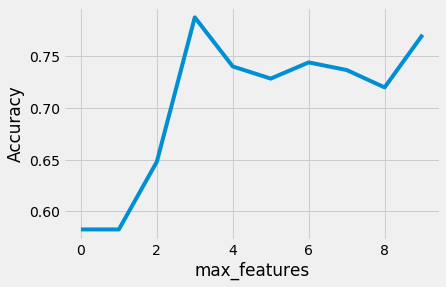

In [20]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.plot(max_feature,accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')


In [21]:
# show the best acuracy and the corresponding max_depth
sorted(zip(accuracy_scores, max_feature))[::-1][0]

(0.787557603686636, 3)

In [22]:
tree = tree_grow(X_train, y_train, max_depth=max_depth, max_features=6)
y_pred = tree_predict(X_test, tree)
print('Accuracy - Testing set:',accuracy_score(y_test, y_pred))

('Accuracy - Testing set:', 0.659447004608295)


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [23]:
# El algoritmo es random forest (Manual)
# DEjar depth=3 o 4

max_depth = 4
num_pct = 10
#max_features = None
#min_gain=0.001

#X_train.shape
n_samples = X_train.shape[0]

np.random.seed(12345)

boostrap = [np.random.choice(a=n_samples, size=n_samples, replace=True) for i in range(num_pct)]
boostrap


[array([4578, 2177, 3492, ..., 4072,  153, 1106]),
 array([3555,  124, 5382, ..., 8472, 6905, 2338]),
 array([4781, 1567, 6242, ..., 4661, 6772, 3827]),
 array([5238, 5977, 2339, ..., 6422, 4561, 3382]),
 array([4651,  135, 2227, ..., 7613, 7002,  675]),
 array([7536, 2486, 3672, ..., 3689, 5691, 5960]),
 array([5821, 6709, 1663, ..., 2643, 3662, 7816]),
 array([1966, 7306,  891, ..., 8410, 3939,  348]),
 array([1850, 7101, 2133, ..., 3667, 8725,  205]),
 array([2829, 7810, 6367, ..., 3747, 6940, 4434])]

In [24]:
from math import log
trees = {}
for i in range(num_pct):
    trees[i] = tree_grow(X_train.iloc[boostrap[i]], y_train.iloc[boostrap[i]], max_depth=max_depth, max_features=int(round(log(X_train.shape[1]),0)))

In [25]:
y_pred = pd.DataFrame(index=X_test.index, columns=list(range(num_pct)))
for i in range(num_pct):
    y_pred.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred = (y_pred.sum(axis=1) >= num_pct*0.5).astype(np.int)
print('Accuracy - Testing set:',accuracy_score(y_test, y_pred))

('Accuracy - Testing set:', 0.7322580645161291)


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [26]:
# Lo mismo usando sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_features=6, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy - Random Forest:', accuracy_score(y_test, y_pred))

('Accuracy - Random Forest:', 0.8426267281105991)


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

### Tuning n_estimators

In [27]:
# Usando sklearn
# list of values to try for n_estimators
from sklearn.model_selection import cross_val_score
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

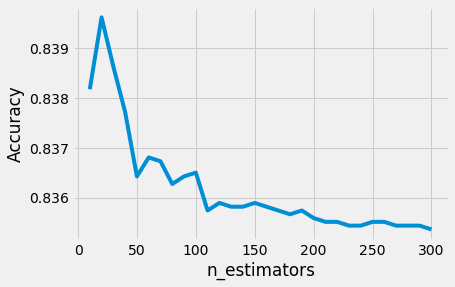

In [28]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [29]:
# show the best acuracy and the corresponding max_depth
sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.8396183455552627, 20)

### Tuning max_features

In [30]:
# list of values to try for max_features
feature_range = range(1, len(X.columns)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

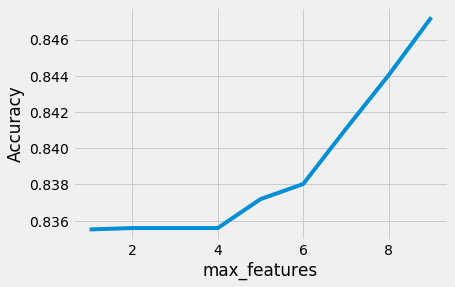

In [31]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [32]:
# show the best acuracy and the corresponding max_features
sorted(zip(accuracy_scores, feature_range))[::-1][0]

(0.8472231112124715, 9)

### Tuning max_depth

In [33]:
# list of values to try for max_depth
depth_range = range(250, 900, 150)

# list to store the average Accuracy for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, max_depth=depth, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

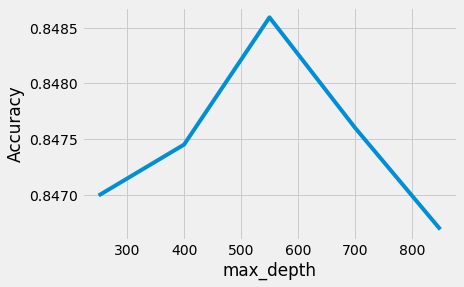

In [34]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [35]:
# show the best acuracy and the corresponding max_depth
sorted(zip(accuracy_scores, depth_range))[::-1][0]

(0.8485917012756696, 550)

### RandomForestClassifier - The best parameters 

In [36]:
# max_features=9 , n_estimators=20 , max_depth=550
clf = RandomForestClassifier(n_estimators=20, max_features=9, random_state=1, max_depth=550,n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy - Random Forest:', accuracy_score(y_test, y_pred))

('Accuracy - Random Forest:', 0.8483870967741935)
